In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
N_FACE = 70
N_POSE = 8

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

Reshape Data into Segments and Prepare for Keras (part5 data)

In [0]:
train_path = './drive/My Drive/636/dataset/part8/trainset.csv'
trainset = pd.read_csv(train_path, index_col=0)
test_path = './drive/My Drive/636/dataset/part8/testset.csv'
testset = pd.read_csv(test_path, index_col=0)

In [99]:
print(trainset.shape, testset.shape)

(45517, 159) (7802, 159)


In [0]:
# get number of features
N_FEATURES = (N_FACE + N_POSE) * 2

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[3:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
X_train = create_segments(trainset, 10)
X_test = create_segments(testset, 10)

In [0]:
y_train = trainset['label'].to_numpy()
y_test = testset['label'].to_numpy()

In [0]:
idx = np.random.permutation(y_train.shape[0])
X_train, y_train = X_train[idx], y_train[idx]

In [0]:
# draw
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Build model

In [13]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, Flatten, Bidirectional, Conv1D, MaxPooling1D
from keras.callbacks import History, EarlyStopping

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]
model_path = './drive/My Drive/636/model/part8/'

Model 1

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_1():
  model = Sequential()
  
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dropout(DROPOUT))

  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [23]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 10, 64)            56832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 69,409
Trainable params: 69,409
Non-trainable params: 0
_________________________________________________________________
Train on 38689 samples, validate on 6828 samples
Epoch 1/100
 - 2s - loss: 0.5520 - acc: 0.7298 - val_loss: 0.4978 -

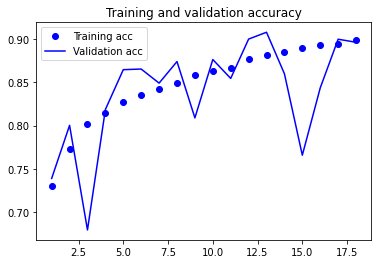

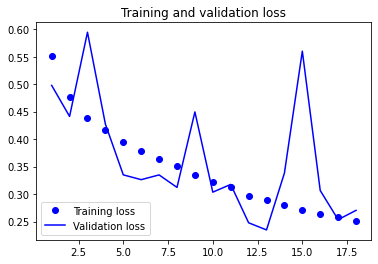

In [24]:
draw(history)

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(LSTM(units = 32))
  model.add(Dropout(DROPOUT))

  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [26]:
# create model
model1_1 = create_model_1()
history = model1_1.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model1_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 55,521
Trainable params: 55,521
Non-trainable params: 0
__________________________________________________

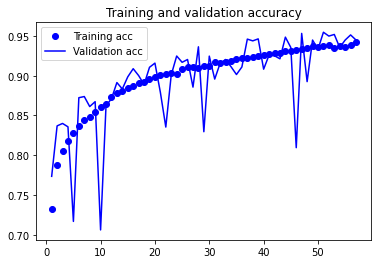

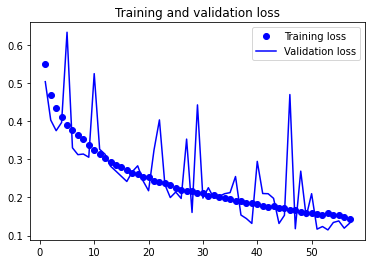

In [72]:
draw(history)

In [27]:
# create model
model1_2 = create_model_1()
history1_2 = model1_2.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score1_2 = model1_2.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10, 64)            10048     
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 55,521
Trainable params: 55,521
Non-trainable params: 0
__________________________________________________

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 64
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_2():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model


In [29]:
# create model
model2 = create_model_2()
history2 = model2.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score2 = model2.evaluate(X_test, y_test, verbose=2)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 9, 64)             20032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                12850     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 32,933
Trainable params: 32,933
Non-trainable params: 0
_________________________________________________________________
Train on 38689 samples, validate on 6828 samples
Epoch 1/100
 - 3s - loss: 1.3076 - acc: 0.7328 - val_loss: 0.4790 

In [30]:
print("test loss: ", score2[0], "test acc: ", score2[1])

test loss:  2.6817013441017026 test acc:  0.5493463277816772


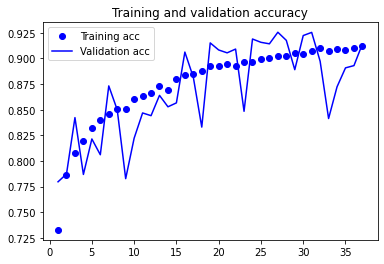

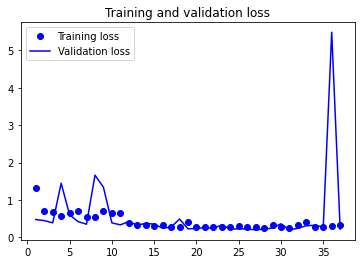

In [31]:
draw(history2)

In [0]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def create_model_3():
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'), 
                            input_shape=(None, TIME_STEP, INPUT_DIM)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=4)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [33]:
# create model
model3 = create_model_3()
X_train_4 = X_train.reshape((X_train.shape[0], 1, TIME_STEP, INPUT_DIM))
history3 = model3.fit(X_train_4, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
X_test_4 = X_test.reshape((X_test.shape[0], 1, TIME_STEP, INPUT_DIM))
score3 = model3.evaluate(X_test_4, y_test, verbose=2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 7, 128)      80000     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1, 128)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 129,473
Trainable params: 129,473
Non-trainable params: 0
________________________________________________

In [34]:
print("test loss: ", score3[0], "test acc: ", score3[1])

test loss:  4.400146087253638 test acc:  0.5930530428886414


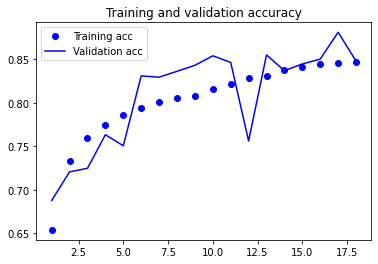

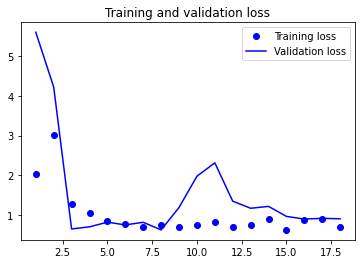

In [35]:
draw(history3)

In [106]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_model_4():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(64, activation='relu', input_shape=(TIME_STEP, INPUT_DIM), 
                 return_sequences = True))
  model.add(Dropout(0.5))
  model.add(LSTM(32, activation='relu'))
  model.add(Dropout(0.5)) 
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]
model4 = create_model_4()
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score4 = model4.evaluate(X_test, y_test)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 10, 32)            5024      
_________________________________________________________________
lstm_16 (LSTM)               (None, 10, 64)            24832     
_________________________________________________________________
dropout_54 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_55 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 129       
Total params: 128,801
Trainable params: 128,801
Non-trainable params: 0
_______________________________________________

KeyboardInterrupt: ignored

In [0]:
print("test loss: ", score4[0], "test acc: ", score4[1])

In [0]:
draw(history4)

In [0]:
def create_model_5():
  model = Sequential()
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [40]:
model5 = create_model_5()
history5 = model5.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5 = model5.evaluate(X_test, y_test, verbose=2)

Train on 36413 samples, validate on 9104 samples
Epoch 1/100
 - 15s - loss: 0.5278 - acc: 0.7417 - val_loss: 0.5552 - val_acc: 0.7235
Epoch 2/100
 - 14s - loss: 0.4440 - acc: 0.7945 - val_loss: 0.4032 - val_acc: 0.8166
Epoch 3/100
 - 14s - loss: 0.4073 - acc: 0.8187 - val_loss: 0.4213 - val_acc: 0.7905
Epoch 4/100
 - 14s - loss: 0.3787 - acc: 0.8335 - val_loss: 0.3617 - val_acc: 0.8449
Epoch 5/100
 - 14s - loss: 0.3496 - acc: 0.8467 - val_loss: 0.3246 - val_acc: 0.8641
Epoch 6/100
 - 14s - loss: 0.3272 - acc: 0.8585 - val_loss: 0.2740 - val_acc: 0.8810
Epoch 7/100
 - 14s - loss: 0.3081 - acc: 0.8686 - val_loss: 0.4084 - val_acc: 0.7739
Epoch 8/100
 - 14s - loss: 0.2913 - acc: 0.8789 - val_loss: 0.2633 - val_acc: 0.8980
Epoch 9/100
 - 14s - loss: 0.2832 - acc: 0.8826 - val_loss: 0.2437 - val_acc: 0.9103
Epoch 10/100
 - 14s - loss: 0.2696 - acc: 0.8880 - val_loss: 0.3274 - val_acc: 0.8420
Epoch 11/100
 - 14s - loss: 0.2600 - acc: 0.8923 - val_loss: 0.2970 - val_acc: 0.8597
Epoch 12/100
 

In [41]:
model5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               113152    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 113,281
Trainable params: 113,281
Non-trainable params: 0
_________________________________________________________________


In [42]:
score5

[2.0110608477687015, 0.5337092876434326]

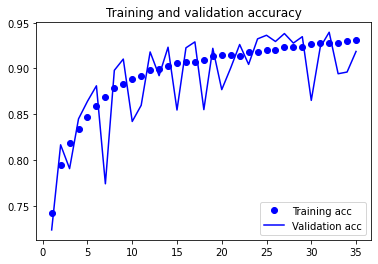

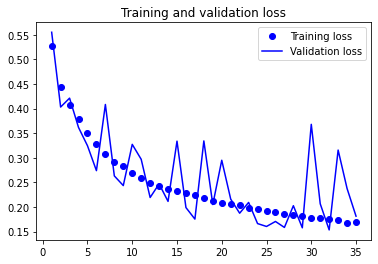

In [43]:
draw(history5)

In [0]:
def create_model5_1():
  model = Sequential()
  model.add(Bidirectional(LSTM(128)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [45]:
model5_1 = create_model5_1()
history5_1 = model5_1.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_1 = model5_1.evaluate(X_test, y_test, verbose=2)

Train on 36413 samples, validate on 9104 samples
Epoch 1/100
 - 15s - loss: 0.5264 - acc: 0.7417 - val_loss: 0.5664 - val_acc: 0.6830
Epoch 2/100
 - 14s - loss: 0.4399 - acc: 0.7967 - val_loss: 0.4141 - val_acc: 0.8091
Epoch 3/100
 - 14s - loss: 0.3961 - acc: 0.8220 - val_loss: 0.3537 - val_acc: 0.8508
Epoch 4/100
 - 14s - loss: 0.3628 - acc: 0.8426 - val_loss: 0.3674 - val_acc: 0.8391
Epoch 5/100
 - 14s - loss: 0.3374 - acc: 0.8529 - val_loss: 0.3205 - val_acc: 0.8777
Epoch 6/100
 - 14s - loss: 0.3125 - acc: 0.8638 - val_loss: 0.2482 - val_acc: 0.9109
Epoch 7/100
 - 14s - loss: 0.2928 - acc: 0.8755 - val_loss: 0.4327 - val_acc: 0.8203
Epoch 8/100
 - 14s - loss: 0.2802 - acc: 0.8808 - val_loss: 0.2742 - val_acc: 0.8645
Epoch 9/100
 - 14s - loss: 0.2663 - acc: 0.8889 - val_loss: 0.3190 - val_acc: 0.8372
Epoch 10/100
 - 14s - loss: 0.2559 - acc: 0.8931 - val_loss: 0.2136 - val_acc: 0.9178
Epoch 11/100
 - 14s - loss: 0.2500 - acc: 0.8954 - val_loss: 0.2754 - val_acc: 0.8917
Epoch 12/100
 

In [46]:
score5_1

[2.4309960707315335, 0.5553703904151917]

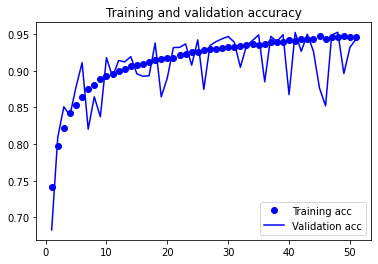

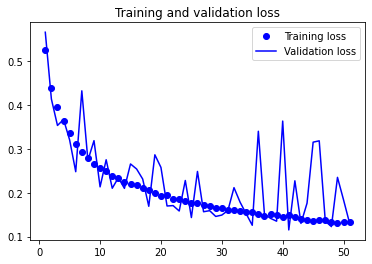

In [47]:
draw(history5_1)

In [0]:
def create_model5_2():
  model = Sequential()
  model.add(Bidirectional(LSTM(64, return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [49]:
model5_2 = create_model5_2()
history5_2 = model5_2.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_2 = model5_2.evaluate(X_test, y_test, verbose=2)

Train on 36413 samples, validate on 9104 samples
Epoch 1/100
 - 28s - loss: 0.5163 - acc: 0.7504 - val_loss: 0.4214 - val_acc: 0.8166
Epoch 2/100
 - 27s - loss: 0.4376 - acc: 0.7980 - val_loss: 0.4091 - val_acc: 0.7980
Epoch 3/100
 - 27s - loss: 0.3949 - acc: 0.8257 - val_loss: 0.5266 - val_acc: 0.7322
Epoch 4/100
 - 27s - loss: 0.3678 - acc: 0.8399 - val_loss: 0.3496 - val_acc: 0.8455
Epoch 5/100
 - 27s - loss: 0.3463 - acc: 0.8512 - val_loss: 0.4860 - val_acc: 0.7188
Epoch 6/100
 - 27s - loss: 0.3198 - acc: 0.8620 - val_loss: 0.2665 - val_acc: 0.8913
Epoch 7/100
 - 27s - loss: 0.2983 - acc: 0.8723 - val_loss: 0.2709 - val_acc: 0.8948
Epoch 8/100
 - 27s - loss: 0.2837 - acc: 0.8784 - val_loss: 0.2815 - val_acc: 0.8880
Epoch 9/100
 - 27s - loss: 0.2699 - acc: 0.8873 - val_loss: 0.4017 - val_acc: 0.7837
Epoch 10/100
 - 27s - loss: 0.2623 - acc: 0.8907 - val_loss: 0.3107 - val_acc: 0.8407
Epoch 11/100
 - 27s - loss: 0.2472 - acc: 0.8969 - val_loss: 0.2307 - val_acc: 0.9040
Epoch 12/100
 

[1.743781648933175, 0.5537042021751404]


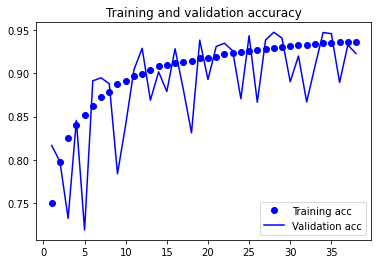

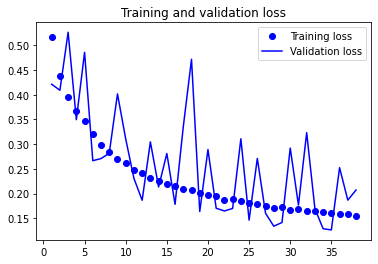

In [50]:
print(score5_2)
draw(history5_2)

In [0]:
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156

In [0]:
def create_model_6():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [53]:
# create model
model6 = create_model_6()
history6 = model6.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score6 = model6.evaluate(X_test, y_test, verbose=2)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10, 64)            10048     
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 10, 64)            33280     
_________________________________________________________________
dropout_20 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 10, 32)            12544     
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [54]:
score6

[1.9622820391625517, 0.563188910484314]

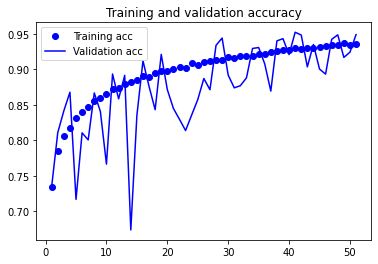

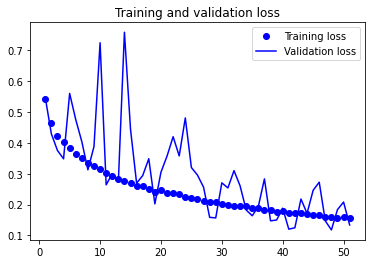

In [55]:
draw(history6)

In [0]:
def create_model6_1():
  model = Sequential()
  model.add(Dense(units = 128, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 64, return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [83]:
model6_1 = create_model_6()
history6_1 = model6_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score6_1 = model6_1.evaluate(X_test, y_test, verbose=2)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 10, 64)            10048     
_________________________________________________________________
cu_dnnlstm_26 (CuDNNLSTM)    (None, 10, 64)            33280     
_________________________________________________________________
dropout_35 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
cu_dnnlstm_27 (CuDNNLSTM)    (None, 10, 32)            12544     
_________________________________________________________________
dropout_36 (Dropout)         (None, 10, 32)            0         
_________________________________________________________________
cu_dnnlstm_28 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_38 (Dense)             (None, 1)               

[1.5816197532315788, 0.5563957691192627]


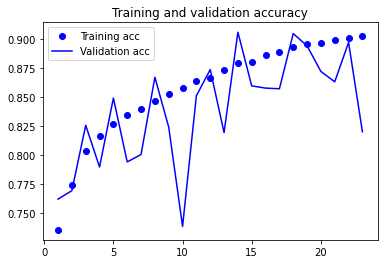

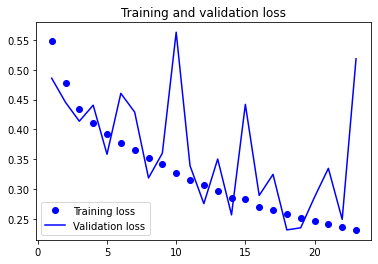

In [81]:
print(score6_1)
draw(history6_1)

In [0]:
def create_model7():
  model = Sequential()
  model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',
                    input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=4))
  model.add(CuDNNLSTM(64))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [60]:
model7 = create_model7()
history7 = model7.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score7 = model7.evaluate(X_test, y_test, verbose=2)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10, 256)           199936    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 256)            0         
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 64)                82432     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 282,433
Trainable params: 282,433
Non-trainable params: 0
_________________________________________________________________
Train on 38689 samples, validate on 6828 samples
Epoch 1/100
 - 3s - loss: 0.5825 - acc: 0.6996 - val_loss: 0.530

[1.7952925065432657, 0.5710074305534363]


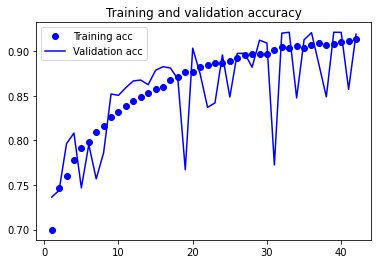

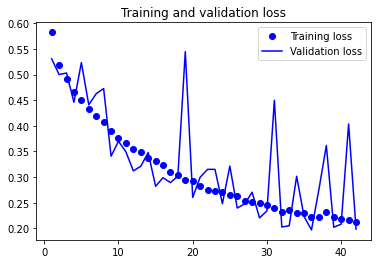

In [61]:
print(score7)
draw(history7)

In [0]:
def create_model7_1():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                    input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=4))
  model.add(CuDNNLSTM(64))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 10, 128)           99968     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 64)                49664     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 149,697
Trainable params: 149,697
Non-trainable params: 0
_________________________________________________________________
Train on 38689 samples, validate on 6828 samples
Epoch 1/100
 - 2s - loss: 0.5913 - acc: 0.6893 - val_loss: 0.511

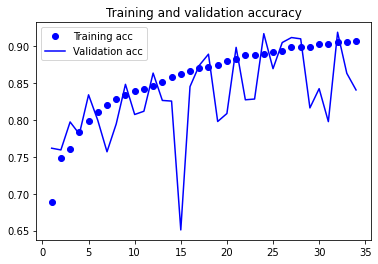

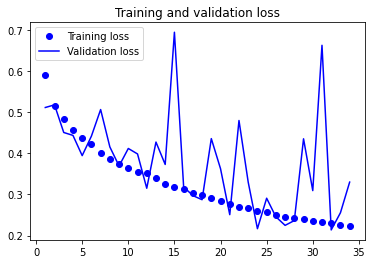

In [63]:
model7_1 = create_model7_1()
history7_1 = model7_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score7_1 = model7_1.evaluate(X_test, y_test, verbose=2)
print(score7_1)
draw(history7_1)

In [0]:
def create_model8():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                    input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=4))
  model.add(CuDNNLSTM(64, return_sequences=True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(32))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 10, 128)           99968     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
cu_dnnlstm_15 (CuDNNLSTM)    (None, 2, 64)             49664     
_________________________________________________________________
dropout_26 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 32)                12544     
_________________________________________________________________
dropout_27 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)               

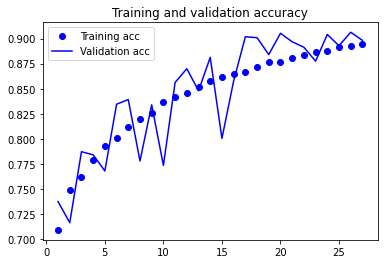

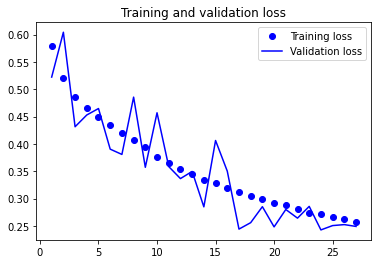

In [65]:
model8 = create_model8()
history8 = model8.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score8 = model8.evaluate(X_test, y_test, verbose=2)
print(score8)
draw(history8)

In [0]:
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, Activation, MaxPooling1D, Dropout, Dense, LSTM, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint

In [0]:
def create_model9():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(LSTM(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [97]:
model9 = create_model9()
history9 = model9.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score9 = model9.evaluate(X_test, y_test, verbose=2)
print(score9)
draw(history9)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 9, 64)             20032     
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 64)             256       
_________________________________________________________________
activation_2 (Activation)    (None, 9, 64)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 129       
Total params: 119,233
Trainable params: 119,105
Non-trainable params: 128
_____________________________________________

ValueError: ignored

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_10():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 9, 64)             20032     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                12850     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 51        
Total params: 32,933
Trainable params: 32,933
Non-trainable params: 0
_________________________________________________________________
Train on 38689 samples, validate on 6828 samples
Epoch 1/100
 - 2s - loss: 2.5704 - acc: 0.6749 - val_loss: 1.3140 

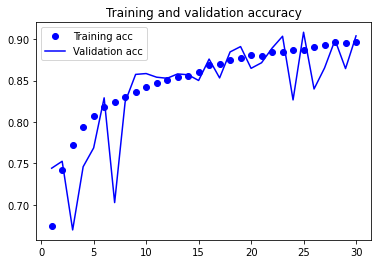

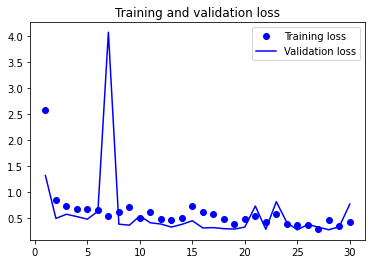

In [70]:
# create model
model10 = create_model_10()
history10 = model10.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score10 = model10.evaluate(X_test, y_test, verbose=2)
print(score10)
draw(history10)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 9, 64)             20032     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 257       
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________
Train on 38689 samples, validate on 6828 samples
Epoch 1/100
 - 2s - loss: 5.5405 - acc: 0.6264 - val_loss: 4.9673 - val_acc: 0.7376
Epoch 2/100
 - 1s - loss: 2.5399 - acc: 0.7295 - val_loss: 1.1949 - val_acc: 0.7665
Epoch 3/100
 - 1s - loss: 2.16

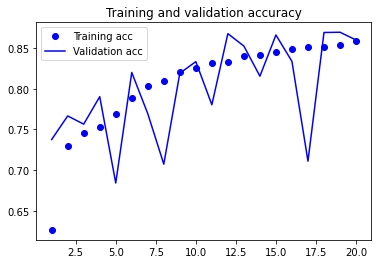

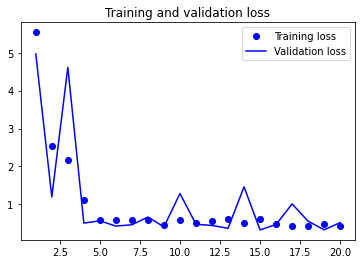

In [71]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_10():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  # model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]
# create model
model10 = create_model_10()
history10 = model10.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score10 = model10.evaluate(X_test, y_test, verbose=2)
print(score10)
draw(history10)

In [85]:
X_train.shape

(45517, 10, 156)

In [0]:
X_train = X_train.reshape(X_train.shape[0], 40, 39, 1)
X_test = X_test.reshape(X_test.shape[0], 40, 39, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
##designing the cnn
def create_model11():
    #1st convolution layer
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
    model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    #Compliling the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

Train on 38689 samples, validate on 6828 samples
Epoch 1/100
 - 13s - loss: 0.7134 - acc: 0.5409 - val_loss: 0.6718 - val_acc: 0.5388
Epoch 2/100
 - 10s - loss: 0.6274 - acc: 0.6219 - val_loss: 0.5239 - val_acc: 0.7718
Epoch 3/100
 - 10s - loss: 0.4882 - acc: 0.7803 - val_loss: 0.4192 - val_acc: 0.8193
Epoch 4/100
 - 10s - loss: 0.4160 - acc: 0.8264 - val_loss: 0.3696 - val_acc: 0.8554
Epoch 5/100
 - 10s - loss: 0.3778 - acc: 0.8457 - val_loss: 0.3373 - val_acc: 0.8519
Epoch 6/100
 - 10s - loss: 0.3331 - acc: 0.8631 - val_loss: 0.2761 - val_acc: 0.8875
Epoch 7/100
 - 10s - loss: 0.2900 - acc: 0.8800 - val_loss: 0.2474 - val_acc: 0.9025
Epoch 8/100
 - 10s - loss: 0.2737 - acc: 0.8890 - val_loss: 0.2554 - val_acc: 0.9033
Epoch 9/100
 - 10s - loss: 0.2521 - acc: 0.8972 - val_loss: 0.2228 - val_acc: 0.9155
Epoch 10/100
 - 10s - loss: 0.2415 - acc: 0.9019 - val_loss: 0.2270 - val_acc: 0.9114
Epoch 11/100
 - 10s - loss: 0.2273 - acc: 0.9078 - val_loss: 0.2037 - val_acc: 0.9162
Epoch 12/100
 

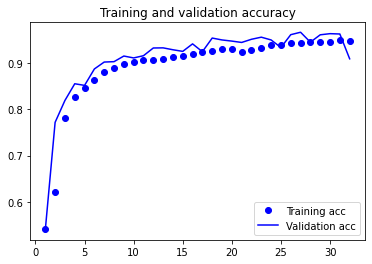

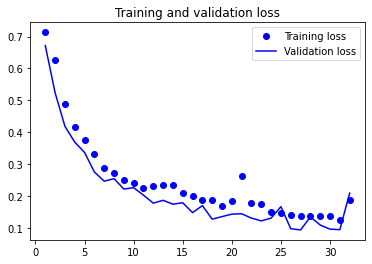

In [95]:
model11 = create_model_11
history11 = model11.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score11 = model11.evaluate(X_test, y_test, verbose=2)
print(score11)
draw(history11)

In [0]:
model.save('cnn_5631.h5')

In [0]:
X_train_4 = X_train.reshape(X_train.shape[0], 40, 39, 1)
X_test_4 = X_test.reshape(X_test.shape[0], 40, 39, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
##designing the cnn
def create_model12():
    #1st convolution layer
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(X_train_4.shape[1:])))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
    # model.add(Dropout(0.5))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    #Compliling the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

In [122]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 38, 37, 64)        640       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 36, 35, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 17, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 18, 17, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 15, 64)        36928     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 6, 64)        

In [123]:
model12 = create_model12()
history12 = model12.fit(X_train_4, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score12 = model12.evaluate(X_test_4, y_test, verbose=2)
print(score12)
draw(history12)

ValueError: ignored